In [1]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

In [2]:
def cleanup_hive_message(mess):
    if('TExecuteStatementResp' in mess):
        mess1 = re.sub('^(.*)infoMessages=\[' , '' , mess)
        mess2 = mess1.split(':')
        # print("HIVE_BEFORE" , mess)
        # print("HIVE_AFTER" , mess2)
        res = mess2[1] + " " +mess2[2] + " " +mess2[3]
        # print("HIVE_AFTER2" , res)
        return res
    return mess


def read_bad_csv_file(name):
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cx_" , "cx+")
        line1 = line1.replace("\n" , "")
        line1 = line1.replace("DataError" , "OperationalError")
        line1 = line1.replace("ProgrammingError" , "OperationalError")
        
        # line1 = re.sub('SQL.*$' , '',  line1)
        sql_error = ""
        
        if('Operational' in line1):
            #print("LINE1_BEFORE" , line1)
            if("[SQL" in line1):
                line1 = re.sub('OperationalError:.*OperationalError(.*)\[SQL.*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
            else:
                line1 = re.sub('OperationalError:.*OperationalError(.*).*$' , '____SQLERROR__\g<1>__SQLERROR____',  line1)
                
            #print("LINE1_AFTER" , line1)
            sql_error = re.sub('.*____SQLERROR__', '',  line1)
            sql_error = re.sub('__SQLERROR____.*', '',  sql_error)
            sql_error = sql_error.replace(") (" , "")
            sql_error = sql_error.replace("\\n" , "")
            sql_error = sql_error.replace("\\" , "")
            sql_error = sql_error[:-2]
            #print("LINE1_AFTER" , sql_error)
        
        # line1 = re.sub('COMPARISON_FAILURE_TOO_MUCH_DIFFS.*$' , 'COMPARISON_FAILURE_TOO_MUCH_DIFFS',  line1)
        # line1 = re.sub('Table .* doesn.*$' , "Table doesn't exist",  line1)
        
        lRegex  = '\s+'
        fields = re.split(lRegex, line1);

        # print(fields)
        # for (i,f) in enumerate(fields):
        #    print(i, f)
        msg_field = " ".join(fields[11:12])
        if(sql_error != ""):
            msg_field = sql_error
        time_field = fields[-1].replace(")" , "")
        row = [fields[1], fields[2], fields[4], fields[3], fields[10], msg_field, time_field]
        rows = rows + [row]

    df = pd.DataFrame(rows);
    df.columns = ['Model' , 'dataset', 'est_dialect' , 'DSN' , 'status' , 'error_message' , 'elapsed_time']
    df['Model'] = df['Model'].str.replace("\(\'" , "")
    df['Model'] = df['Model'].str.replace("\'," , "")
    df['error_message'] = df['error_message'].str.replace("None\)\)" , "SUCCESS")
    df['error_message'] = df['error_message'].str.replace("None\)," , "SUCCESS")
    df['error_message'] = df['error_message'].apply(lambda x : cleanup_hive_message(x))
    return df
    

In [3]:
#df = pd.read_csv('result.txt' , engine='python', sep='\s+', index_col=False,
#                 quotechar="'", header=None)

In [4]:
df = read_bad_csv_file('result.txt')

In [5]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17


In [6]:
# df.elapsed_time.value_counts()

In [7]:
def read_classes(name):
    lClasses = {}
    lCategories = {}
    rows = [];
    with open(name) as f:
        content = f.readlines()
    for line in content:
        line1 = line.replace("cGenerationWrapperFactory::createScikitObject() <class '" , "")
        line1 = line1.replace("'>\n" , "")
        fq_class_name = line1
        short_class_name = fq_class_name.split(".")[-1]
        categeory = ".".join(fq_class_name.split(".")[0:2])
        lClasses[short_class_name] = fq_class_name
        lCategories[short_class_name] = categeory
    return (lClasses , lCategories)


In [8]:
(Classes , Categories) = read_classes("classes.txt")

In [9]:
Classes

{'ARDRegression': 'sklearn.linear_model.bayes.ARDRegression',
 'AdaBoostClassifier': 'sklearn.ensemble.weight_boosting.AdaBoostClassifier',
 'AdaBoostRegressor': 'sklearn.ensemble.weight_boosting.AdaBoostRegressor',
 'BaggingClassifier': 'sklearn.ensemble.bagging.BaggingClassifier',
 'BaggingRegressor': 'sklearn.ensemble.bagging.BaggingRegressor',
 'BayesianRidge': 'sklearn.linear_model.bayes.BayesianRidge',
 'BernoulliNB': 'sklearn.naive_bayes.BernoulliNB',
 'Binarizer': 'sklearn.preprocessing.data.Binarizer',
 'CalibratedClassifierCV': 'sklearn.calibration.CalibratedClassifierCV',
 'DecisionTreeClassifier': 'sklearn.tree.tree.DecisionTreeClassifier',
 'DecisionTreeRegressor': 'sklearn.tree.tree.DecisionTreeRegressor',
 'DummyClassifier': 'sklearn.dummy.DummyClassifier',
 'DummyRegressor': 'sklearn.dummy.DummyRegressor',
 'ElasticNet': 'sklearn.linear_model.coordinate_descent.ElasticNet',
 'ElasticNetCV': 'sklearn.linear_model.coordinate_descent.ElasticNetCV',
 'EllipticEnvelope': 'sk

In [10]:
def get_category(model_name):
    real_name = model_name
    if(model_name.endswith('_pipe')):
        real_name = model_name.replace("_pipe" , "")
    return Categories.get(real_name , "bad_category")

df['model_category'] = df['Model'].apply(get_category)
df.head()


,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn


In [11]:
df_model_datasets = pd.DataFrame(df[['Model' , 'dataset']].groupby(['Model'])['dataset'].value_counts())
datatsets_by_model = df_model_datasets.to_dict()['dataset'].keys()

In [12]:
# datatsets_by_model

In [13]:
datatsets_by_model_dict = {}
for k in datatsets_by_model:
    (m , ds) = k
    if(m not in datatsets_by_model_dict.keys()):
        datatsets_by_model_dict[m] = [ds]
    else:
        datatsets_by_model_dict[m] = datatsets_by_model_dict[m] + [ds]
        
# print(datatsets_by_model_dict)


In [14]:
missing_rows = []
dialects = df.est_dialect.unique()
print(dialects)

print("df.shape", df.shape , df.columns)
for dialect in dialects:
    df1 = df[df['est_dialect'] == dialect]
    # print("df1.shape", dialect, df1.shape , df1.columns)
    for (m , datasets) in datatsets_by_model_dict.items():
        lMissing = 0
        cond2 = (df1['Model'] == m)
        df2 = df1[cond2]
        # print("df2.shape", dialect, m , df2.shape, df2.columns)
        for ds in datasets:
            cond3 = (df2['dataset'] == ds)
            df3 = df2[cond3]
            # print("df3.shape", dialect, m, ds, df3.shape, df3.columns)
            if(df3.shape[0] == 0):
                # print("MISSING_DATA" , [dialect , m , ds])
                missing_rows = missing_rows + [[m , ds, dialect , 'no_dsn' , 'failure' , 'TIMEOUT' , None, get_category(m)]]
                lMissing = lMissing + 1
        if(lMissing >= (len(datasets) // 2)):
            print("MODEL_DATASETS_MISSING" , dialect, m, len(datasets) , lMissing)

missing_data = pd.DataFrame(missing_rows, columns=df.columns)
# missing_data

["'db2'," "'firebird'," "'monetdb'," "'mssql'," "'mysql'," "'oracle',"
 "'pgsql'," "'sqltm'," "'teradata',"]
df.shape (18229, 8) Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')
MODEL_DATASETS_MISSING 'db2', MultinomialNB 1 1
MODEL_DATASETS_MISSING 'db2', RANSACRegressor 4 4
MODEL_DATASETS_MISSING 'db2', RANSACRegressor_pipe 4 4
MODEL_DATASETS_MISSING 'firebird', MultinomialNB 1 0
MODEL_DATASETS_MISSING 'monetdb', MultinomialNB 1 0
MODEL_DATASETS_MISSING 'mssql', MultinomialNB 1 1
MODEL_DATASETS_MISSING 'mssql', RANSACRegressor 4 4
MODEL_DATASETS_MISSING 'mssql', RANSACRegressor_pipe 4 4
MODEL_DATASETS_MISSING 'mysql', MultinomialNB 1 1
MODEL_DATASETS_MISSING 'mysql', RANSACRegressor 4 2
MODEL_DATASETS_MISSING 'mysql', RANSACRegressor_pipe 4 3
MODEL_DATASETS_MISSING 'oracle', MultinomialNB 1 1
MODEL_DATASETS_MISSING 'oracle', RANSACRegressor 4 4
MODEL_DATASETS_MISSING 'oracle', RANSACRegressor_pi

In [15]:
missing_data.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,MultinomialNB,"'DS_BENCH_50_7_0_1__0_1_27D91BF6',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.naive_bayes
1,QuantileTransformer,"'DS_BENCH_200_82_0_1__0_1_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.preprocessing
2,QuantileTransformer,"'DS_BENCH_200_82_0_1__2_3_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.preprocessing
3,QuantileTransformer,"'DS_BENCH_200_82_0_1__8_9_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.preprocessing
4,QuantileTransformer,"'DS_BENCH_50_82_0_1__0_1_64F62F02',","'db2',",no_dsn,failure,TIMEOUT,None,sklearn.preprocessing


In [16]:
df = df.append(missing_data , ignore_index=True)

In [17]:
df[df.error_message == "'"].head(200)

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category


In [18]:
df.shape

(18333, 8)

In [19]:
df.est_dialect.value_counts()

'monetdb',     2037
'firebird',    2037
'db2',         2037
'mssql',       2037
'sqltm',       2037
'oracle',      2037
'mysql',       2037
'pgsql',       2037
'teradata',    2037
Name: est_dialect, dtype: int64

In [20]:
#df0[df0.ds == numpy.na]
df_errors = df[(df.error_message != 'SUCCESS')]
indices = df_errors.error_message.apply(lambda x : 'dialect' not in x)
df_errors = df_errors[indices]


In [21]:
msg_by_estim_and_dsn = pd.DataFrame(df_errors.groupby(['est_dialect'])['error_message'].value_counts())

In [22]:
msg_by_estim_and_dsn.sort_values(by='error_message' , ascending=False)

,,error_message
est_dialect,error_message,
"'firebird',",'DatabaseError:(fdb.fbcore.DatabaseError),134
"'db2',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'teradata',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'sqltm',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'pgsql',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'oracle',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'mysql',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'monetdb',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90
"'firebird',","""Exception:CODE_GENERATION_NOT_IMPLEMENTED",90


In [23]:
pd.DataFrame(df.error_message.value_counts())

,error_message
SUCCESS,17036
"""Exception:CODE_GENERATION_NOT_IMPLEMENTED",810
'DatabaseError:(fdb.fbcore.DatabaseError),134
"""Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS",110
TIMEOUT,104
) inputs not the same size,45
) Illegal argumen,12
'DatabaseError:(teradata.api.DatabaseError),12
") GDK reported error: GDKload: cannot open: name=6, ext=tai",8
: SQLNumResultCols failed: [IBM][CLI Driver][DB2/LINUXX8664] SQL0840N Too many items were returned in a SELECT list. SQLSTATE=54004 SQLCODE=-84,6


In [24]:

lGroupBy = df[df.status == 'failure'].groupby(['error_message'])

In [25]:
#lGroupBy['rows'].describe()

In [26]:
real_errors = df[df.error_message == '"Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS']

In [27]:
real_errors.Model.value_counts()

OneVsRestClassifier        27
NuSVC_pipe                 24
FastICA                    24
FactorAnalysis             17
Lars                        8
AdaBoostClassifier          3
AdaBoostClassifier_pipe     3
EllipticEnvelope            2
IsolationForest_pipe        1
IsolationForest             1
Name: Model, dtype: int64

In [28]:
lNotImplementedMessage = '"Exception:CODE_GENERATION_NOT_IMPLEMENTED'
not_impl_errors = df[df.error_message == lNotImplementedMessage]
not_impl_errors.Model.value_counts()

MiniBatchSparsePCA           162
SparsePCA                    162
KernelPCA                    162
LatentDirichletAllocation    162
NMF                          162
Name: Model, dtype: int64

In [29]:
# df.pivot(index = 'Model', values='status' , columns='est_dialect')

In [30]:
df.columns

Index(['Model', 'dataset', 'est_dialect', 'DSN', 'status', 'error_message',
       'elapsed_time', 'model_category'],
      dtype='object')

In [31]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category
0,LGBMClassifier,"'DS_BENCH_200_22_0_1__0_1_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,4,lightgbm.sklearn
1,LGBMClassifier,"'DS_BENCH_200_22_0_1__2_3_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
2,LGBMClassifier,"'DS_BENCH_200_22_0_1__8_9_DB7350D0',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,5,lightgbm.sklearn
3,LGBMClassifier,"'DS_BENCH_200_7_0_1__0_1_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn
4,LGBMClassifier,"'DS_BENCH_200_7_0_1__2_3_27D91BF6',","'db2',","'db2+ibm_db://db:db@localhost:50000/db',","'success',",SUCCESS,17,lightgbm.sklearn


In [32]:
df['status'] = df['status'].apply(lambda x : 1 if('failure' in x) else 0)
df['status_2'] = df['status'].apply(lambda x : 1)


In [33]:
def strip_punc(x):
    x = x .replace("'" , "")
    x = x .replace("(" , "")
    x = x .replace("," , "")
    return x

df['dialect'] = df['est_dialect'].apply(lambda x : strip_punc(x))
df['Model'] = df['Model'].apply(lambda x : strip_punc(x))
df['dataset'] = df['dataset'].apply(lambda x : strip_punc(x))
df = df[df['model_category'] != 'sklearn.dummy']
df = df[df['error_message'] != lNotImplementedMessage]



In [34]:
df.head()

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect
0,LGBMClassifier,DS_BENCH_200_22_0_1__0_1_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,4,lightgbm.sklearn,1,db2
1,LGBMClassifier,DS_BENCH_200_22_0_1__2_3_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1,db2
2,LGBMClassifier,DS_BENCH_200_22_0_1__8_9_DB7350D0,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,5,lightgbm.sklearn,1,db2
3,LGBMClassifier,DS_BENCH_200_7_0_1__0_1_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2
4,LGBMClassifier,DS_BENCH_200_7_0_1__2_3_27D91BF6,"'db2',","'db2+ibm_db://db:db@localhost:50000/db',",0,SUCCESS,17,lightgbm.sklearn,1,db2


In [35]:
# How many tests were used for each model category
pvt_count = pd.pivot_table(df, index='model_category', values='status_2' , columns=['dialect'],  aggfunc=[np.sum], margins=True)
pvt_count.head(pvt_count.shape[0])


sum                                            \
dialect                         db2 firebird monetdb mssql mysql oracle pgsql   
model_category                                                                  
lightgbm.sklearn                 48       48      48    48    48     48    48   
sklearn.calibration              36       36      36    36    36     36    36   
sklearn.covariance               12       12      12    12    12     12    12   
sklearn.decomposition            90       90      90    90    90     90    90   
sklearn.discriminant_analysis    36       36      36    36    36     36    36   
sklearn.ensemble                252      252     252   252   252    252   252   
sklearn.feature_selection       162      162     162   162   162    162   162   
sklearn.kernel_ridge             12       12      12    12    12     12    12   
sklearn.linear_model            488      488     488   488   488    488   488   
sklearn.multiclass               72       72      72    72    72     72    72   
sklearn.naive_bayes              73       73      73    73    73     73    73   
sklearn.neural_network           48       48      48    48    48     48    48   
sklearn.pipeline                 54       54      54    54    54     54    54   
sklearn.preprocessing           216      216     216   216   216    216   216   
sklearn.svm                     156      156     156   156   156    156   156   
sklearn.tree                     96       96      96    96    96     96    96   
xgboost.sklearn                  48       48      48    48    48     48    48   
All                            1899     1899    1899  1899  1899   1899  1899   

                                                     
dialect                       sqltm teradata    All  
model_category                                       
lightgbm.sklearn                 48       48    432  
sklearn.calibration              36       36    324  
sklearn.covariance               12       12    108  
sklearn.decomposition            90       90    810  
sklearn.discriminant_analysis    36       36    324  
sklearn.ensemble                252      252   2268  
sklearn.feature_selection       162      162   1458  
sklearn.kernel_ridge             12       12    108  
sklearn.linear_model            488      488   4392  
sklearn.multiclass               72       72    648  
sklearn.naive_bayes              73       73    657  
sklearn.neural_network           48       48    432  
sklearn.pipeline                 54       54    486  
sklearn.preprocessing           216      216   1944  
sklearn.svm                     156      156   1404  
sklearn.tree                     96       96    864  
xgboost.sklearn                  48       48    432  
All                            1899     1899  17091

In [36]:
pvt = pd.pivot_table(df, index='model_category', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)

In [37]:
pvt.head(pvt.shape[0])

mean                                \
dialect                             db2  firebird   monetdb     mssql   
model_category                                                          
lightgbm.sklearn               0.000000  0.083333  0.041667  0.000000   
sklearn.calibration            0.000000  0.000000  0.083333  0.000000   
sklearn.covariance             0.166667  0.166667  0.250000  0.166667   
sklearn.decomposition          0.033333  0.100000  0.277778  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.083333  0.000000   
sklearn.ensemble               0.007937  0.202381  0.039683  0.000000   
sklearn.feature_selection      0.000000  0.000000  0.049383  0.000000   
sklearn.kernel_ridge           0.250000  0.583333  0.000000  0.000000   
sklearn.linear_model           0.022541  0.002049  0.030738  0.018443   
sklearn.multiclass             0.041667  0.041667  0.097222  0.041667   
sklearn.naive_bayes            0.013699  0.082192  0.054795  0.013699   
sklearn.neural_network         0.020833  0.000000  0.041667  0.000000   
sklearn.pipeline               0.000000  0.000000  0.055556  0.000000   
sklearn.preprocessing          0.055556  0.083333  0.087963  0.000000   
sklearn.svm                    0.019231  0.256410  0.057692  0.019231   
sklearn.tree                   0.000000  0.000000  0.031250  0.000000   
xgboost.sklearn                0.000000  0.000000  0.041667  0.000000   
All                            0.021590  0.074250  0.062138  0.011058   

                                                                       \
dialect                           mysql    oracle     pgsql     sqltm   
model_category                                                          
lightgbm.sklearn               0.000000  0.000000  0.000000  0.000000   
sklearn.calibration            0.000000  0.000000  0.000000  0.000000   
sklearn.covariance             0.166667  0.083333  0.166667  0.166667   
sklearn.decomposition          0.033333  0.033333  0.033333  0.033333   
sklearn.discriminant_analysis  0.000000  0.000000  0.000000  0.000000   
sklearn.ensemble               0.000000  0.000000  0.000000  0.000000   
sklearn.feature_selection      0.000000  0.000000  0.000000  0.000000   
sklearn.kernel_ridge           0.000000  0.000000  0.000000  0.000000   
sklearn.linear_model           0.012295  0.018443  0.018443  0.018443   
sklearn.multiclass             0.041667  0.069444  0.041667  0.041667   
sklearn.naive_bayes            0.013699  0.027397  0.013699  0.013699   
sklearn.neural_network         0.000000  0.000000  0.000000  0.000000   
sklearn.pipeline               0.000000  0.000000  0.000000  0.000000   
sklearn.preprocessing          0.000000  0.000000  0.027778  0.055556   
sklearn.svm                    0.019231  0.038462  0.019231  0.019231   
sklearn.tree                   0.000000  0.000000  0.000000  0.000000   
xgboost.sklearn                0.000000  0.020833  0.000000  0.000000   
All                            0.009479  0.014218  0.014218  0.017378   

                                                   
dialect                        teradata       All  
model_category                                     
lightgbm.sklearn               0.062500  0.020833  
sklearn.calibration            0.000000  0.009259  
sklearn.covariance             0.166667  0.166667  
sklearn.decomposition          0.033333  0.067901  
sklearn.discriminant_analysis  0.000000  0.009259  
sklearn.ensemble               0.055556  0.033951  
sklearn.feature_selection      0.000000  0.005487  
sklearn.kernel_ridge           0.000000  0.092593  
sklearn.linear_model           0.016393  0.017532  
sklearn.multiclass             0.041667  0.050926  
sklearn.naive_bayes            0.082192  0.035008  
sklearn.neural_network         0.000000  0.006944  
sklearn.pipeline               0.000000  0.006173  
sklearn.preprocessing          0.055556  0.040638  
sklearn.svm                    0.057692  0.056268  
sklearn.tree                   

In [38]:
df.to_csv('report_extensive_tests.csv')

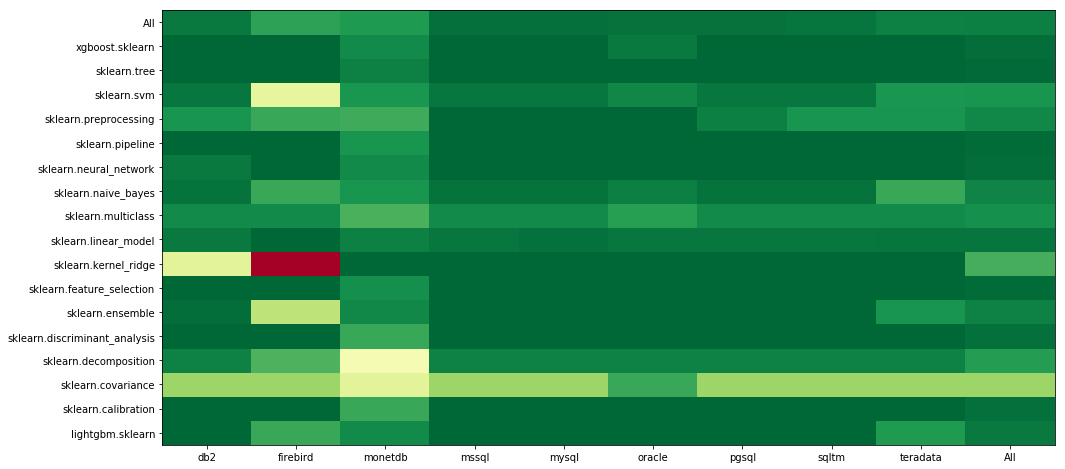

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.pcolor(1-pvt, cmap='RdYlGn')
plt.yticks(np.arange(0.5, len(pvt.index), 1), pvt.index)
plt.xticks(np.arange(0.5, len(pvt.columns), 1), [col[1] for col in pvt.columns])
fig = plt.gcf()
fig.set_size_inches(16, 8)

plt.show()       
    

In [40]:
Category_Labels = df.model_category.unique()


In [41]:
Category_Labels

array(['lightgbm.sklearn', 'sklearn.calibration', 'sklearn.covariance',
       'sklearn.decomposition', 'sklearn.discriminant_analysis',
       'sklearn.ensemble', 'sklearn.feature_selection',
       'sklearn.kernel_ridge', 'sklearn.linear_model',
       'sklearn.multiclass', 'sklearn.naive_bayes',
       'sklearn.neural_network', 'sklearn.pipeline',
       'sklearn.preprocessing', 'sklearn.svm', 'sklearn.tree',
       'xgboost.sklearn'], dtype=object)

In [42]:





for cat in Category_Labels:
    print("ERROR_REPORT_FOR_CATEGORY" , cat)
    df1 = df[df.model_category == cat]
    real_errors = df1 # df1[df1.error_message != "SUCCESS"]
    if(real_errors.shape[0] > 0):
        msg_by_estim_and_dsn = pd.DataFrame(real_errors.groupby(['est_dialect'])['error_message'].value_counts())
        from IPython.core.display import display, HTML
        display(msg_by_estim_and_dsn)
        pvt1 = pd.pivot_table(df1, index='Model', values='status' , columns=['dialect'],  aggfunc=[np.mean], margins=True)
        display(pvt1)
    else:
        print("NO_ERROR_FOR_CATEGORY" , cat)
    

ERROR_REPORT_FOR_CATEGORY lightgbm.sklearn


error_message
est_dialect error_message                                             
'db2',      SUCCESS                                                 48
'firebird', SUCCESS                                                 44
            'DatabaseError:(fdb.fbcore.DatabaseError)                4
'monetdb',  SUCCESS                                                 46
            ) Illegal argumen                                        1
            ) inputs not the same size                               1
'mssql',    SUCCESS                                                 48
'mysql',    SUCCESS                                                 48
'oracle',   SUCCESS                                                 48
'pgsql',    SUCCESS                                                 48
'sqltm',    SUCCESS                                                 48
'teradata', SUCCESS                                                 45
            'DatabaseError:(teradata.api.DatabaseError)              3

mean                                                     \
dialect              db2  firebird   monetdb mssql mysql oracle pgsql sqltm   
Model                                                                         
LGBMClassifier       0.0  0.166667  0.055556   0.0   0.0    0.0   0.0   0.0   
LGBMClassifier_pipe  0.0  0.000000  0.055556   0.0   0.0    0.0   0.0   0.0   
LGBMRegressor        0.0  0.166667  0.000000   0.0   0.0    0.0   0.0   0.0   
LGBMRegressor_pipe   0.0  0.000000  0.000000   0.0   0.0    0.0   0.0   0.0   
All                  0.0  0.083333  0.041667   0.0   0.0    0.0   0.0   0.0   

                                         
dialect              teradata       All  
Model                                    
LGBMClassifier       0.000000  0.024691  
LGBMClassifier_pipe  0.166667  0.024691  
LGBMRegressor        0.000000  0.018519  
LGBMRegressor_pipe   0.000000  0.000000  
All                  0.062500  0.020833

ERROR_REPORT_FOR_CATEGORY sklearn.calibration


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        36
'firebird', SUCCESS                                                        36
'monetdb',  SUCCESS                                                        33
            "DatabaseError:(pymonetdb.exceptions.DatabaseEr...              1
            ) Illegal argumen                                               1
            ) inputs not the same size                                      1
'mssql',    SUCCESS                                                        36
'mysql',    SUCCESS                                                        36
'oracle',   SUCCESS                                                        36
'pgsql',    SUCCESS                                                        36
'sqltm',    SUCCESS                                                        36
'teradata', SUCCESS                                                        36

mean                                              \
dialect                      db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                          
CalibratedClassifierCV       0.0      0.0  0.111111   0.0   0.0    0.0   0.0   
CalibratedClassifierCV_pipe  0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
All                          0.0      0.0  0.083333   0.0   0.0    0.0   0.0   

                                                      
dialect                     sqltm teradata       All  
Model                                                 
CalibratedClassifierCV        0.0      0.0  0.012346  
CalibratedClassifierCV_pipe   0.0      0.0  0.006173  
All                           0.0      0.0  0.009259

ERROR_REPORT_FOR_CATEGORY sklearn.covariance


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        10
            'InternalError:(ibm_db_dbi.InternalError)                       2
'firebird', SUCCESS                                                        10
            'DatabaseError:(fdb.fbcore.DatabaseError)                       2
'monetdb',  SUCCESS                                                         9
            TIMEOUT                                                         2
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                        10
            8631, b'Internal error: Server stack limit has ...              2
'mysql',    SUCCESS                                                        10
            1436, "Thread stack overrun:  1237888 bytes use...              2
'oracle',   SUCCESS                                                        11
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                        10
            ) stack depth limit exceededHINT:  Increase the...              2
'sqltm',    SUCCESS                                                        10
            ) Expression tree is too large (maximum depth 1000              2
'teradata', SUCCESS                                                        10
            'DatabaseError:(teradata.api.DatabaseError)                     2

mean                                          \
dialect                     db2  firebird   monetdb     mssql     mysql   
Model                                                                     
EllipticEnvelope       0.333333  0.333333  0.333333  0.333333  0.333333   
EllipticEnvelope_pipe  0.000000  0.000000  0.166667  0.000000  0.000000   
All                    0.166667  0.166667  0.250000  0.166667  0.166667   

                                                                         
dialect                  oracle     pgsql     sqltm  teradata       All  
Model                                                                    
EllipticEnvelope       0.166667  0.333333  0.333333  0.333333  0.314815  
EllipticEnvelope_pipe  0.000000  0.000000  0.000000  0.000000  0.018519  
All                    0.083333  0.166667  0.166667  0.166667  0.166667

ERROR_REPORT_FOR_CATEGORY sklearn.decomposition


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                  81
            'DatabaseError:(fdb.fbcore.DatabaseError)                 6
            "DatabaseError:(fdb.fbcore.DatabaseError)                 3
'monetdb',  SUCCESS                                                  65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS             20
            ) inputs not the same size                                5
'mssql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'pgsql',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  87
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                                    \
dialect              db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                        
FactorAnalysis  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000   
FastICA         0.166667  0.333333  0.222222  0.166667  0.166667  0.166667   
IncrementalPCA  0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
PCA             0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
TruncatedSVD    0.000000  0.166667  0.055556  0.000000  0.000000  0.000000   
All             0.033333  0.100000  0.277778  0.033333  0.033333  0.033333   

                                                        
dialect            pgsql     sqltm  teradata       All  
Model                                                   
FactorAnalysis  0.000000  0.000000  0.000000  0.111111  
FastICA         0.166667  0.166667  0.166667  0.191358  
IncrementalPCA  0.000000  0.000000  0.000000  0.006173  
PCA             0.000000  0.000000  0.000000  0.006173  
TruncatedSVD    0.000000  0.000000  0.000000  0.024691  
All             0.033333  0.033333  0.033333  0.067901

ERROR_REPORT_FOR_CATEGORY sklearn.discriminant_analysis


error_message
est_dialect error_message                                        
'db2',      SUCCESS                                            36
'firebird', SUCCESS                                            36
'monetdb',  SUCCESS                                            33
            ) inputs not the same size                          2
            'DBAPIError:(builtins.BrokenPipeError)              1
'mssql',    SUCCESS                                            36
'mysql',    SUCCESS                                            36
'oracle',   SUCCESS                                            36
'pgsql',    SUCCESS                                            36
'sqltm',    SUCCESS                                            36
'teradata', SUCCESS                                            36

mean                                        \
dialect                          db2 firebird   monetdb mssql mysql oracle   
Model                                                                        
LinearDiscriminantAnalysis       0.0      0.0  0.111111   0.0   0.0    0.0   
LinearDiscriminantAnalysis_pipe  0.0      0.0  0.055556   0.0   0.0    0.0   
All                              0.0      0.0  0.083333   0.0   0.0    0.0   

                                                                
dialect                         pgsql sqltm teradata       All  
Model                                                           
LinearDiscriminantAnalysis        0.0   0.0      0.0  0.012346  
LinearDiscriminantAnalysis_pipe   0.0   0.0      0.0  0.006173  
All                               0.0   0.0      0.0  0.009259

ERROR_REPORT_FOR_CATEGORY sklearn.ensemble


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       250
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       201
            'DatabaseError:(fdb.fbcore.DatabaseError)                      51
'monetdb',  SUCCESS                                                       242
            ) Illegal argumen                                               5
            ) inputs not the same size                                      5
'mssql',    SUCCESS                                                       252
'mysql',    SUCCESS                                                       252
'oracle',   SUCCESS                                                       252
'pgsql',    SUCCESS                                                       252
'sqltm',    SUCCESS                                                       252
'teradata', SUCCESS                                                       238
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    8
            'DatabaseError:(teradata.api.DatabaseError)                     6

mean                                  \
dialect                               db2  firebird   monetdb mssql mysql   
Model                                                                       
AdaBoostClassifier               0.000000  1.000000  0.055556   0.0   0.0   
AdaBoostClassifier_pipe          0.000000  1.000000  0.055556   0.0   0.0   
AdaBoostRegressor                0.000000  0.000000  0.000000   0.0   0.0   
AdaBoostRegressor_pipe           0.000000  0.000000  0.000000   0.0   0.0   
BaggingClassifier                0.000000  0.000000  0.055556   0.0   0.0   
BaggingClassifier_pipe           0.055556  0.000000  0.055556   0.0   0.0   
BaggingRegressor                 0.000000  0.166667  0.000000   0.0   0.0   
BaggingRegressor_pipe            0.000000  0.000000  0.000000   0.0   0.0   
ExtraTreesClassifier             0.000000  0.333333  0.055556   0.0   0.0   
ExtraTreesClassifier_pipe        0.055556  0.000000  0.055556   0.0   0.0   
ExtraTreesRegressor              0.000000  0.166667  0.000000   0.0   0.0   
ExtraTreesRegressor_pipe         0.000000  0.166667  0.000000   0.0   0.0   
GradientBoostingClassifier       0.000000  0.000000  0.055556   0.0   0.0   
GradientBoostingClassifier_pipe  0.000000  0.000000  0.055556   0.0   0.0   
GradientBoostingRegressor        0.000000  0.000000  0.000000   0.0   0.0   
GradientBoostingRegressor_pipe   0.000000  0.000000  0.000000   0.0   0.0   
IsolationForest                  0.000000  0.500000  0.000000   0.0   0.0   
IsolationForest_pipe             0.000000  0.500000  0.000000   0.0   0.0   
RandomForestClassifier           0.000000  0.000000  0.055556   0.0   0.0   
RandomForestClassifier_pipe      0.000000  0.000000  0.055556   0.0   0.0   
RandomForestRegressor            0.000000  0.000000  0.000000   0.0   0.0   
RandomForestRegressor_pipe       0.000000  0.000000  0.000000   0.0   0.0   
All                              0.007937  0.202381  0.039683   0.0   0.0   

                                                                        
dialect                         oracle pgsql sqltm  teradata       All  
Model                                                                   
AdaBoostClassifier                 0.0   0.0   0.0  0.166667  0.135802  
AdaBoostClassifier_pipe            0.0   0.0   0.0  0.166667  0.135802  
AdaBoostRegressor                  0.0   0.0   0.0  0.000000  0.000000  
AdaBoostRegressor_pipe             0.0   0.0   0.0  0.000000  0.000000  
BaggingClassifier                  0.0   0.0   0.0  0.000000  0.006173  
BaggingClassifier_pipe             0.0   0.0   0.0  0.000000  0.012346  
BaggingRegressor                   0.0   0.0   0.0  0.000000  0.018519  
BaggingRegressor_pipe              0.0   0.0   0.0  0.000000  0.000000  
ExtraTreesClassifier               0.0   0.0   0.0  0.000000  0.043210  
ExtraTreesClassifier_pipe          0.0   0.0   0.0  0.000000  0.012346  
ExtraTreesRegressor                0.0   0.0   0.0  0.000000  0.018519  
ExtraTreesRegressor_pipe           0.0   0.0   0.0  0.000000  0.018519  
GradientBoostingClassifier         0.0   0.0   0.0  0.000000  0.006173  
GradientBoostingClassifier_pipe    0.0   0.0   0.0  0.000000  0.006173  
GradientBoostingRegressor          0.0   0.0   0.0  0.000000  0.000000  
GradientBoostingRegressor_pipe     0.0   0.0   0.0  0.000000  0.000000  
IsolationForest                    0.0   0.0   0.0  0.666667  0.129630  
IsolationForest_pipe               0.0   0.0   0.0  0.666667  0.129630  
RandomForestClassifier             0.0   0.0   0.0  0.000000  0.006173  
RandomForestClassifier_pipe        0.0   0.0   0.0  0.000000  0.006173  
RandomForestRegressor              0.0   0.0   0.0  0.000000  0.000000  
RandomForestRegressor_pipe         0.0   0.0   0.0  0.000000  0.000000  
All                                0.0   0.0   0.0  0.055556  0.033951

ERROR_REPORT_FOR_CATEGORY sklearn.feature_selection


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       162
'firebird', SUCCESS                                                       162
'monetdb',  SUCCESS                                                       154
            ) GDK reported error: GDKload: cannot open: nam...              8
'mssql',    SUCCESS                                                       162
'mysql',    SUCCESS                                                       162
'oracle',   SUCCESS                                                       162
'pgsql',    SUCCESS                                                       162
'sqltm',    SUCCESS                                                       162
'teradata', SUCCESS                                                       162

mean                                              \
dialect                  db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                      
GenericUnivariateSelect  0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
RFE                      0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
RFECV                    0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
SelectFdr                0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
SelectFpr                0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
SelectFromModel          0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
SelectFwe                0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
SelectKBest              0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
SelectPercentile         0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
All                      0.0      0.0  0.049383   0.0   0.0    0.0   0.0   

                                                  
dialect                 sqltm teradata       All  
Model                                             
GenericUnivariateSelect   0.0      0.0  0.006173  
RFE                       0.0      0.0  0.006173  
RFECV                     0.0      0.0  0.000000  
SelectFdr                 0.0      0.0  0.006173  
SelectFpr                 0.0      0.0  0.006173  
SelectFromModel           0.0      0.0  0.006173  
SelectFwe                 0.0      0.0  0.006173  
SelectKBest               0.0      0.0  0.006173  
SelectPercentile          0.0      0.0  0.006173  
All                       0.0      0.0  0.005487

ERROR_REPORT_FOR_CATEGORY sklearn.kernel_ridge


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                         9
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', 'DatabaseError:(fdb.fbcore.DatabaseError)                       7
            SUCCESS                                                         5
'monetdb',  SUCCESS                                                        12
'mssql',    SUCCESS                                                        12
'mysql',    SUCCESS                                                        12
'oracle',   SUCCESS                                                        12
'pgsql',    SUCCESS                                                        12
'sqltm',    SUCCESS                                                        12
'teradata', SUCCESS                                                        12

mean                                                   \
dialect            db2  firebird monetdb mssql mysql oracle pgsql sqltm   
Model                                                                     
KernelRidge       0.00  0.333333     0.0   0.0   0.0    0.0   0.0   0.0   
KernelRidge_pipe  0.50  0.833333     0.0   0.0   0.0    0.0   0.0   0.0   
All               0.25  0.583333     0.0   0.0   0.0    0.0   0.0   0.0   

                                     
dialect          teradata       All  
Model                                
KernelRidge           0.0  0.037037  
KernelRidge_pipe      0.0  0.148148  
All                   0.0  0.092593

ERROR_REPORT_FOR_CATEGORY sklearn.linear_model


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       477
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                       487
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'monetdb',  SUCCESS                                                       473
            ) inputs not the same size                                     14
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mssql',    SUCCESS                                                       479
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'mysql',    SUCCESS                                                       482
            TIMEOUT                                                         5
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'oracle',   SUCCESS                                                       479
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'pgsql',    SUCCESS                                                       479
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'sqltm',    SUCCESS                                                       479
            TIMEOUT                                                         8
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    1
'teradata', SUCCESS                                                       480
            TIMEOUT                                                         7
            'DatabaseError:(teradata.api.DatabaseError)                     1

mean                                \
dialect                                db2  firebird   monetdb     mssql   
Model                                                                      
ARDRegression                     0.000000  0.000000  0.000000  0.000000   
ARDRegression_pipe                0.000000  0.000000  0.000000  0.000000   
BayesianRidge                     0.000000  0.000000  0.000000  0.000000   
BayesianRidge_pipe                0.000000  0.000000  0.000000  0.000000   
ElasticNet                        0.000000  0.000000  0.000000  0.000000   
ElasticNetCV                      0.000000  0.000000  0.000000  0.000000   
ElasticNetCV_pipe                 0.000000  0.000000  0.000000  0.000000   
ElasticNet_pipe                   0.000000  0.000000  0.000000  0.000000   
Lars                              0.166667  0.166667  0.166667  0.166667   
LarsCV                            0.000000  0.000000  0.000000  0.000000   
LarsCV_pipe                       0.000000  0.000000  0.000000  0.000000   
Lars_pipe                         0.000000  0.000000  0.000000  0.000000   
Lasso                             0.000000  0.000000  0.000000  0.000000   
LassoCV                           0.000000  0.000000  0.000000  0.000000   
LassoCV_pipe                      0.166667  0.000000  0.000000  0.000000   
LassoLars                         0.000000  0.000000  0.000000  0.000000   
LassoLarsCV                       0.000000  0.000000  0.000000  0.000000   
LassoLarsCV_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLarsIC                       0.000000  0.000000  0.000000  0.000000   
LassoLarsIC_pipe                  0.000000  0.000000  0.000000  0.000000   
LassoLars_pipe                    0.000000  0.000000  0.000000  0.000000   
Lasso_pipe                        0.000000  0.000000  0.000000  0.000000   
LinearRegression                  0.000000  0.000000  0.000000  0.000000   
LinearRegression_pipe             0.000000  0.000000  0.000000  0.000000   
LogisticRegression                0.000000  0.000000  0.055556  0.000000   
LogisticRegressionCV              0.000000  0.000000  0.055556  0.000000   
LogisticRegressionCV_pipe         0.000000  0.000000  0.055556  0.000000   
LogisticRegression_pipe           0.000000  0.000000  0.055556  0.000000   
OrthogonalMatchingPursuit         0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV       0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuitCV_pipe  0.000000  0.000000  0.000000  0.000000   
OrthogonalMatchingPursuit_pipe    0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveClassifier       0.000000  0.000000  0.055556  0.000000   
PassiveAggressiveClassifier_pipe  0.000000  0.000000  0.055556  0.000000   
PassiveAggressiveRegressor        0.000000  0.000000  0.000000  0.000000   
PassiveAggressiveRegressor_pipe   0.000000  0.000000  0.000000  0.000000   
Perceptron                        0.000000  0.000000  0.055556  0.000000   
Perceptron_pipe                   0.000000  0.000000  0.055556  0.000000   
RANSACRegressor                   1.000000  0.000000  0.000000  1.000000   
RANSACRegressor_pipe              1.000000  0.000000  0.000000  1.000000   
Ridge                             0.000000  0.000000  0.000000  0.000000   
RidgeCV                           0.000000  0.000000  0.000000  0.000000   
RidgeCV_pipe                      0.000000  0.000000  0.000000  0.000000   
RidgeClassifier                   0.000000  0.000000  0.055556  0.000000   
RidgeClassifierCV                 0.000000  0.000000  0.055556  0.000000   
RidgeClassifierCV_pipe            0.000000  0.000000  0.055556  0.000000   
RidgeClassifier_pipe              0.000000  0.000000  0.055556  0.000000   
Ridge_pipe                        0.000000  0.000000  0.000000  0.000000   
SGDClassifier                     0.000000  0.000000  0.055556  0.000000   
SGDClassifier_pipe                0.055556  0.000000  0.055556  0.000000   
SGDRegress

ERROR_REPORT_FOR_CATEGORY sklearn.multiclass


error_message
est_dialect error_message                                              
'db2',      SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'firebird', SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'monetdb',  SUCCESS                                                  65
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
            ) Illegal argumen                                         2
            ) inputs not the same size                                2
'mssql',    SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'mysql',    SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'oracle',   SUCCESS                                                  67
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
            'DatabaseError:(cx+Oracle.DatabaseError)                  2
'pgsql',    SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'sqltm',    SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3
'teradata', SUCCESS                                                  69
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS              3

mean                                          \
dialect                        db2  firebird   monetdb     mssql     mysql   
Model                                                                        
OneVsOneClassifier        0.000000  0.000000  0.055556  0.000000  0.000000   
OneVsOneClassifier_pipe   0.000000  0.000000  0.055556  0.000000  0.000000   
OneVsRestClassifier       0.166667  0.166667  0.222222  0.166667  0.166667   
OneVsRestClassifier_pipe  0.000000  0.000000  0.055556  0.000000  0.000000   
All                       0.041667  0.041667  0.097222  0.041667  0.041667   

                                                                            
dialect                     oracle     pgsql     sqltm  teradata       All  
Model                                                                       
OneVsOneClassifier        0.000000  0.000000  0.000000  0.000000  0.006173  
OneVsOneClassifier_pipe   0.111111  0.000000  0.000000  0.000000  0.018519  
OneVsRestClassifier       0.166667  0.166667  0.166667  0.166667  0.172840  
OneVsRestClassifier_pipe  0.000000  0.000000  0.000000  0.000000  0.006173  
All                       0.069444  0.041667  0.041667  0.041667  0.050926

ERROR_REPORT_FOR_CATEGORY sklearn.naive_bayes


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        72
            TIMEOUT                                                         1
'firebird', SUCCESS                                                        67
            'DatabaseError:(fdb.fbcore.DatabaseError)                       6
'monetdb',  SUCCESS                                                        69
            ) GDK reported error: BATgroupsum: b and g must...              2
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'mysql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'oracle',   SUCCESS                                                        71
            'DatabaseError:(cx+Oracle.DatabaseError)                        1
            TIMEOUT                                                         1
'pgsql',    SUCCESS                                                        72
            TIMEOUT                                                         1
'sqltm',    SUCCESS                                                        72
            TIMEOUT                                                         1
'teradata', SUCCESS                                                        67
            TIMEOUT                                                         6

mean                                                    \
dialect                db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                          
BernoulliNB       0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
BernoulliNB_pipe  0.000000  0.000000  0.055556  0.000000  0.000000  0.055556   
GaussianNB        0.000000  0.333333  0.055556  0.000000  0.000000  0.000000   
GaussianNB_pipe   0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
MultinomialNB     1.000000  0.000000  0.000000  1.000000  1.000000  1.000000   
All               0.013699  0.082192  0.054795  0.013699  0.013699  0.027397   

                                                          
dialect              pgsql     sqltm  teradata       All  
Model                                                     
BernoulliNB       0.000000  0.000000  0.000000  0.006173  
BernoulliNB_pipe  0.000000  0.000000  0.000000  0.012346  
GaussianNB        0.000000  0.000000  0.277778  0.074074  
GaussianNB_pipe   0.000000  0.000000  0.000000  0.006173  
MultinomialNB     1.000000  1.000000  1.000000  0.777778  
All               0.013699  0.013699  0.082192  0.035008

ERROR_REPORT_FOR_CATEGORY sklearn.neural_network


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        47
            : Statement Execute Failed: [IBM][CLI Driver][D...              1
'firebird', SUCCESS                                                        48
'monetdb',  SUCCESS                                                        46
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                        48
'mysql',    SUCCESS                                                        48
'oracle',   SUCCESS                                                        48
'pgsql',    SUCCESS                                                        48
'sqltm',    SUCCESS                                                        48
'teradata', SUCCESS                                                        48

mean                                              \
dialect                  db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                      
MLPClassifier       0.000000      0.0  0.055556   0.0   0.0    0.0   0.0   
MLPClassifier_pipe  0.055556      0.0  0.055556   0.0   0.0    0.0   0.0   
MLPRegressor        0.000000      0.0  0.000000   0.0   0.0    0.0   0.0   
MLPRegressor_pipe   0.000000      0.0  0.000000   0.0   0.0    0.0   0.0   
All                 0.020833      0.0  0.041667   0.0   0.0    0.0   0.0   

                                             
dialect            sqltm teradata       All  
Model                                        
MLPClassifier        0.0      0.0  0.006173  
MLPClassifier_pipe   0.0      0.0  0.012346  
MLPRegressor         0.0      0.0  0.000000  
MLPRegressor_pipe    0.0      0.0  0.000000  
All                  0.0      0.0  0.006944

ERROR_REPORT_FOR_CATEGORY sklearn.pipeline


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                        54
'firebird', SUCCESS                                                        54
'monetdb',  SUCCESS                                                        51
            ) GDK reported error: BATproject: does not matc...              1
            ) Illegal argumen                                               1
            ) inputs not the same size                                      1
'mssql',    SUCCESS                                                        54
'mysql',    SUCCESS                                                        54
'oracle',   SUCCESS                                                        54
'pgsql',    SUCCESS                                                        54
'sqltm',    SUCCESS                                                        54
'teradata', SUCCESS                                                        54

mean                                                             \
dialect        db2 firebird   monetdb mssql mysql oracle pgsql sqltm teradata   
Model                                                                           
FeatureUnion   0.0      0.0  0.055556   0.0   0.0    0.0   0.0   0.0      0.0   
Pipeline       0.0      0.0  0.055556   0.0   0.0    0.0   0.0   0.0      0.0   
Pipeline_pipe  0.0      0.0  0.055556   0.0   0.0    0.0   0.0   0.0      0.0   
All            0.0      0.0  0.055556   0.0   0.0    0.0   0.0   0.0      0.0   

                         
dialect             All  
Model                    
FeatureUnion   0.006173  
Pipeline       0.006173  
Pipeline_pipe  0.006173  
All            0.006173

ERROR_REPORT_FOR_CATEGORY sklearn.preprocessing


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       204
            : SQLNumResultCols failed: [IBM][CLI Driver][DB...              6
            TIMEOUT                                                         6
'firebird', SUCCESS                                                       198
            'DatabaseError:(fdb.fbcore.DatabaseError)                      18
'monetdb',  SUCCESS                                                       197
            TIMEOUT                                                        17
            ) inputs not the same size                                      2
'mssql',    SUCCESS                                                       216
'mysql',    SUCCESS                                                       216
'oracle',   SUCCESS                                                       216
'pgsql',    SUCCESS                                                       210
            ) target lists can have at most 1664 entrie                     6
'sqltm',    SUCCESS                                                       204
            ) too many columns in result se                                 6
            ) too many terms in compound SELEC                              6
'teradata', SUCCESS                                                       204
            "DatabaseError:(teradata.api.DatabaseError)                     6
            TIMEOUT                                                         6

mean                                         \
dialect                   db2  firebird   monetdb mssql mysql oracle   
Model                                                                  
Binarizer            0.000000  0.000000  0.111111   0.0   0.0    0.0   
Imputer              0.000000  0.000000  0.111111   0.0   0.0    0.0   
LabelBinarizer       0.000000  0.000000  0.000000   0.0   0.0    0.0   
LabelEncoder         0.000000  0.000000  0.000000   0.0   0.0    0.0   
MaxAbsScaler         0.000000  0.000000  0.111111   0.0   0.0    0.0   
MinMaxScaler         0.000000  0.000000  0.111111   0.0   0.0    0.0   
Normalizer           0.000000  0.000000  0.055556   0.0   0.0    0.0   
OneHotEncoder        0.000000  0.000000  0.111111   0.0   0.0    0.0   
PolynomialFeatures   0.333333  0.333333  0.166667   0.0   0.0    0.0   
QuantileTransformer  0.333333  0.666667  0.055556   0.0   0.0    0.0   
RobustScaler         0.000000  0.000000  0.111111   0.0   0.0    0.0   
StandardScaler       0.000000  0.000000  0.111111   0.0   0.0    0.0   
All                  0.055556  0.083333  0.087963   0.0   0.0    0.0   

                                                             
dialect                 pgsql     sqltm  teradata       All  
Model                                                        
Binarizer            0.000000  0.000000  0.000000  0.012346  
Imputer              0.000000  0.000000  0.000000  0.012346  
LabelBinarizer       0.000000  0.000000  0.000000  0.000000  
LabelEncoder         0.000000  0.000000  0.000000  0.000000  
MaxAbsScaler         0.000000  0.000000  0.000000  0.012346  
MinMaxScaler         0.000000  0.000000  0.000000  0.012346  
Normalizer           0.000000  0.000000  0.000000  0.006173  
OneHotEncoder        0.000000  0.000000  0.000000  0.012346  
PolynomialFeatures   0.333333  0.333333  0.333333  0.203704  
QuantileTransformer  0.000000  0.333333  0.333333  0.191358  
RobustScaler         0.000000  0.000000  0.000000  0.012346  
StandardScaler       0.000000  0.000000  0.000000  0.012346  
All                  0.027778  0.055556  0.055556  0.040638

ERROR_REPORT_FOR_CATEGORY sklearn.svm


error_message
est_dialect error_message                                                    
'db2',      SUCCESS                                                       153
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'firebird', SUCCESS                                                       116
            'DatabaseError:(fdb.fbcore.DatabaseError)                      40
'monetdb',  SUCCESS                                                       147
            ) inputs not the same size                                      4
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            ) GDK reported error: BATproject: does not matc...              2
'mssql',    SUCCESS                                                       153
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'mysql',    SUCCESS                                                       153
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'oracle',   SUCCESS                                                       150
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
            TIMEOUT                                                         3
'pgsql',    SUCCESS                                                       153
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'sqltm',    SUCCESS                                                       153
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3
'teradata', SUCCESS                                                       147
            TIMEOUT                                                         6
            "Exception:COMPARISON_FAILURE_TOO_MANY_DIFFS                    3

mean                                                    \
dialect                db2  firebird   monetdb     mssql     mysql    oracle   
Model                                                                          
LinearSVC         0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
LinearSVC_pipe    0.000000  0.000000  0.055556  0.000000  0.000000  0.000000   
LinearSVR         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
NuSVC             0.000000  0.166667  0.055556  0.000000  0.000000  0.000000   
NuSVC_pipe        0.166667  0.500000  0.222222  0.166667  0.166667  0.166667   
NuSVR             0.000000  0.166667  0.000000  0.000000  0.000000  0.000000   
NuSVR_pipe        0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
OneClassSVM       0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
OneClassSVM_pipe  0.000000  0.333333  0.000000  0.000000  0.000000  0.000000   
SVC               0.000000  0.166667  0.055556  0.000000  0.000000  0.166667   
SVC_pipe          0.000000  0.500000  0.055556  0.000000  0.000000  0.000000   
SVR               0.000000  0.500000  0.000000  0.000000  0.000000  0.000000   
SVR_pipe          0.000000  0.833333  0.000000  0.000000  0.000000  0.000000   
All               0.019231  0.256410  0.057692  0.019231  0.019231  0.038462   

                                                          
dialect              pgsql     sqltm  teradata       All  
Model                                                     
LinearSVC         0.000000  0.000000  0.000000  0.006173  
LinearSVC_pipe    0.000000  0.000000  0.000000  0.006173  
LinearSVR         0.000000  0.000000  0.000000  0.000000  
LinearSVR_pipe    0.000000  0.000000  0.000000  0.000000  
NuSVC             0.000000  0.000000  0.166667  0.043210  
NuSVC_pipe        0.166667  0.166667  0.166667  0.209877  
NuSVR             0.000000  0.000000  0.000000  0.018519  
NuSVR_pipe        0.000000  0.000000  0.000000  0.055556  
OneClassSVM       0.000000  0.000000  0.000000  0.037037  
OneClassSVM_pipe  0.000000  0.000000  0.000000  0.037037  
SVC               0.000000  0.000000  0.166667  0.061728  
SVC_pipe          0.000000  0.000000  0.000000  0.061728  
SVR               0.000000  0.000000  0.000000  0.055556  
SVR_pipe          0.000000  0.000000  0.000000  0.092593  
All               0.019231  0.019231  0.057692  0.056268

ERROR_REPORT_FOR_CATEGORY sklearn.tree


error_message
est_dialect error_message                            
'db2',      SUCCESS                                96
'firebird', SUCCESS                                96
'monetdb',  SUCCESS                                93
            ) inputs not the same size              2
            ) Illegal argumen                       1
'mssql',    SUCCESS                                96
'mysql',    SUCCESS                                96
'oracle',   SUCCESS                                96
'pgsql',    SUCCESS                                96
'sqltm',    SUCCESS                                96
'teradata', SUCCESS                                96

mean                                              \
dialect                      db2 firebird   monetdb mssql mysql oracle pgsql   
Model                                                                          
DecisionTreeClassifier       0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
DecisionTreeClassifier_pipe  0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
DecisionTreeRegressor        0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
DecisionTreeRegressor_pipe   0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
ExtraTreeClassifier          0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
ExtraTreeClassifier_pipe     0.0      0.0  0.055556   0.0   0.0    0.0   0.0   
ExtraTreeRegressor           0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
ExtraTreeRegressor_pipe      0.0      0.0  0.000000   0.0   0.0    0.0   0.0   
All                          0.0      0.0  0.031250   0.0   0.0    0.0   0.0   

                                                      
dialect                     sqltm teradata       All  
Model                                                 
DecisionTreeClassifier        0.0      0.0  0.006173  
DecisionTreeClassifier_pipe   0.0      0.0  0.006173  
DecisionTreeRegressor         0.0      0.0  0.000000  
DecisionTreeRegressor_pipe    0.0      0.0  0.000000  
ExtraTreeClassifier           0.0      0.0  0.000000  
ExtraTreeClassifier_pipe      0.0      0.0  0.006173  
ExtraTreeRegressor            0.0      0.0  0.000000  
ExtraTreeRegressor_pipe       0.0      0.0  0.000000  
All                           0.0      0.0  0.003472

ERROR_REPORT_FOR_CATEGORY xgboost.sklearn


error_message
est_dialect error_message                                          
'db2',      SUCCESS                                              48
'firebird', SUCCESS                                              48
'monetdb',  SUCCESS                                              46
            ) Illegal argumen                                     1
            ) inputs not the same size                            1
'mssql',    SUCCESS                                              48
'mysql',    SUCCESS                                              48
'oracle',   SUCCESS                                              47
            'DatabaseError:(cx+Oracle.DatabaseError)              1
'pgsql',    SUCCESS                                              48
'sqltm',    SUCCESS                                              48
'teradata', SUCCESS                                              48

mean                                                       \
dialect             db2 firebird   monetdb mssql mysql    oracle pgsql sqltm   
Model                                                                          
XGBClassifier       0.0      0.0  0.055556   0.0   0.0  0.000000   0.0   0.0   
XGBClassifier_pipe  0.0      0.0  0.055556   0.0   0.0  0.055556   0.0   0.0   
XGBRegressor        0.0      0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   
XGBRegressor_pipe   0.0      0.0  0.000000   0.0   0.0  0.000000   0.0   0.0   
All                 0.0      0.0  0.041667   0.0   0.0  0.020833   0.0   0.0   

                                       
dialect            teradata       All  
Model                                  
XGBClassifier           0.0  0.006173  
XGBClassifier_pipe      0.0  0.012346  
XGBRegressor            0.0  0.000000  
XGBRegressor_pipe       0.0  0.000000  
All                     0.0  0.006944

In [43]:
df[df.model_category == "bad_category"]

,Model,dataset,est_dialect,DSN,status,error_message,elapsed_time,model_category,status_2,dialect


'db2',


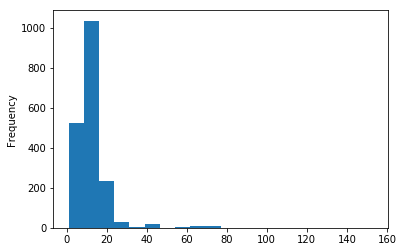

'firebird',


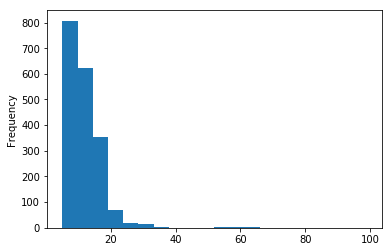

'monetdb',


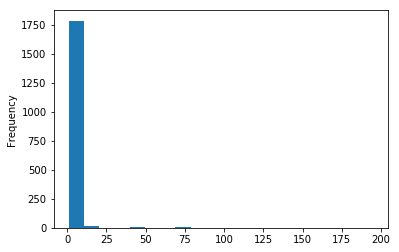

'mssql',


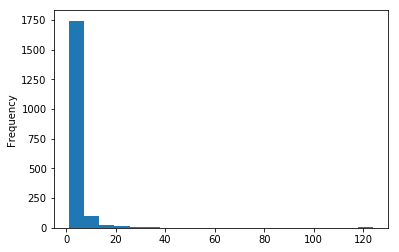

'mysql',


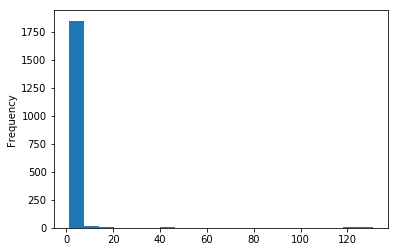

'oracle',


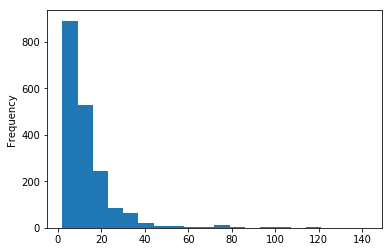

'pgsql',


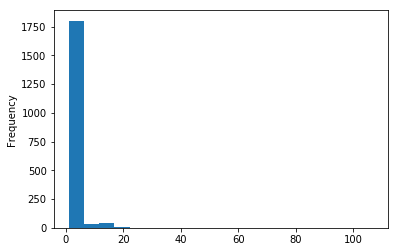

'sqltm',


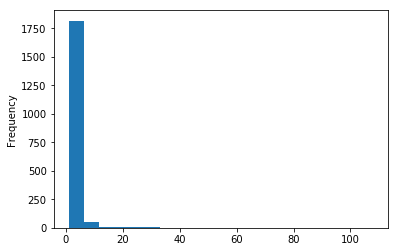

'teradata',


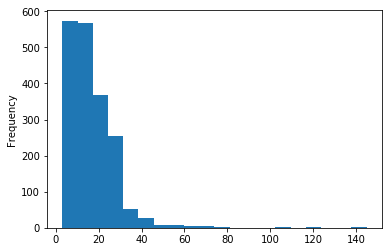

In [44]:
def to_float(x):
    try:
        return float(x)
    except:
        # print("PROBLEM_CONVERTING" , x)
        return None

import matplotlib.pyplot as plt
for dialect in dialects:
    print(dialect)
    df1 = df[df.est_dialect == dialect] # .sample(4000)
    times = df1['elapsed_time'].apply(to_float)
    # times= times[times > 100]
    times.plot(kind='hist' , bins=20)
    plt.show()
